# Task 2a: Sign Detection with YOLOv11

**Student:** Luigi Camilleri
**Student ID:** 0312805L    
**Model:** YOLOv11


This notebook implements a YOLOv11 object detector to detect Maltese traffic signs. It covers:
1.  **Dataset Preparation**: Setting up the data.yaml configuration and specifying its path
2.  **Model Training**: Fine-tuning a pre-trained `YOLOv11` model.
3.  **Evaluation**: Evaluating the best-performing YOLOv11 model on the test set.
4.  **Inference & Analytics**: Visualising evaluation curves and comparing ground-truth labels with model predictions.

In [38]:
import importlib
import subprocess
import sys
import os
import glob
import matplotlib.pyplot as plt

%matplotlib inline


#  Package bootstrap helper
def ensure_package(pkg: str, import_name: str | None = None, pip_name: str | None = None):
    try:
        return importlib.import_module(import_name or pkg)
    except ImportError:
        pip_target = pip_name or pkg
        print(f"Installing missing package: {pip_target}")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", pip_target],
            stdout=subprocess.DEVNULL
        )
        return importlib.import_module(import_name or pkg)

# Ensure third-party packages
torch = ensure_package("torch")
ultralytics = ensure_package("ultralytics")

#  Reproducibility
torch.manual_seed(42)

print("Environment ready: all dependencies installed and imported.")

Environment ready: all dependencies installed and imported.


## 1. Dataset Preparation

The dataset for the YOLOv11 model is prepared automatically by the data.yaml file in the YOLO_COCO dataset

In [40]:
# Path to the data.yaml file
DATA_YAML = 'Assignment Material/YOLO_COCO/data.yaml'

## 2. Model Training

In [ ]:
from ultralytics import YOLO

# Loads a pre-trained YOLOv11 model
model = YOLO('yolo11m.pt')
# Trains the model and gets the training results
results = model.train(
    data=DATA_YAML,
    epochs=100,
    imgsz=640,
    batch=8,
    project='models',
    name='yolov11',
    exist_ok=True
)


Ultralytics 8.4.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Assignment Materials/YOLO_COCO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov11, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

## 3. Evaluating on Test Set

This section loads the best fine tuned YOLOv11 model and evaluates its performance on the test set, generating metrics and plots to assess detection accuracy.

In [5]:
# Evaluates the best trained model on the test set and generate plots
best_model = YOLO('models/yolov11/weights/best.pt')
test_results = best_model.val(
    data=DATA_YAML,
    split="test",    # explicitly uses the test set
    plots=True       # generates plots like confusion matrix, PR curves
)

Ultralytics 8.3.137  Python-3.12.7 torch-2.7.0+cpu CPU (AMD Ryzen 5 5500U with Radeon Graphics)
YOLO11m summary (fused): 126 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access  (ping: 0.40.1 ms, read: 473.073.8 MB/s, size: 1343.9 KB)


val: Scanning C:\Users\luigi\OneDrive\Desktop\Univerity of Malta\Studies\Year 3\Advanced CV\Assignments\Project\Code\Assignment Material\YOLO_COCO\labels\test... 116 images, 0 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<00:00, 353.54it/s]

val: New cache created: C:\Users\luigi\OneDrive\Desktop\Univerity of Malta\Studies\Year 3\Advanced CV\Assignments\Project\Code\Assignment Material\YOLO_COCO\labels\test.cache



C:\Users\luigi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:48<00:00,  6.05s/it]


                   all        116        130      0.828       0.67      0.768      0.655
Blind-Spot Mirror (Convex)         14         15      0.913      0.933      0.913      0.794
    No Entry (One Way)         37         40      0.772       0.76      0.873      0.704
No Through Road (T-Sign)          7          7      0.761      0.461      0.601      0.506
   Pedestrian Crossing         22         25      0.875       0.64      0.772      0.645
      Roundabout Ahead          9          9      0.679      0.333      0.509      0.452
                  Stop         34         34      0.968      0.889      0.938      0.832
Speed: 2.5ms preprocess, 295.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val2


## 4. Analytics & Visualization

This section provides functions and tools to visualize the results and analytics of the YOLOv11 model, including displaying images and evaluation plots.

In [42]:
# Directory containing YOLOv11's best model's outputs
val_dir = 'runs/detect/val'

# Function to display images from a folder in a grid format
def show_images_from_folder(
    folder,
    title,
    patterns,
    cols = 2,
    img_size=5
):

    image_paths = []
    for pattern in patterns:
        image_paths.extend(glob.glob(os.path.join(folder, pattern)))
    image_paths.sort()

    if not image_paths:
        print(f'No images found in {folder}')
        return

    n = len(image_paths)
    rows = (n + cols - 1) // cols # Logic to get number of rows needed

    # Figure size scales with rows
    fig_width = cols * img_size
    fig_height = rows * img_size

    # Create subplots
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(fig_width, fig_height),
        constrained_layout=True
    )

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for ax, img_path in zip(axes, image_paths):
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_aspect('equal')  
        ax.axis('off')

    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close(fig)


### Evaluation Plots

Displays key evaluation plots such as the confusion matrix, precision-recall curves and F1-curves to help interpret the model's performance.

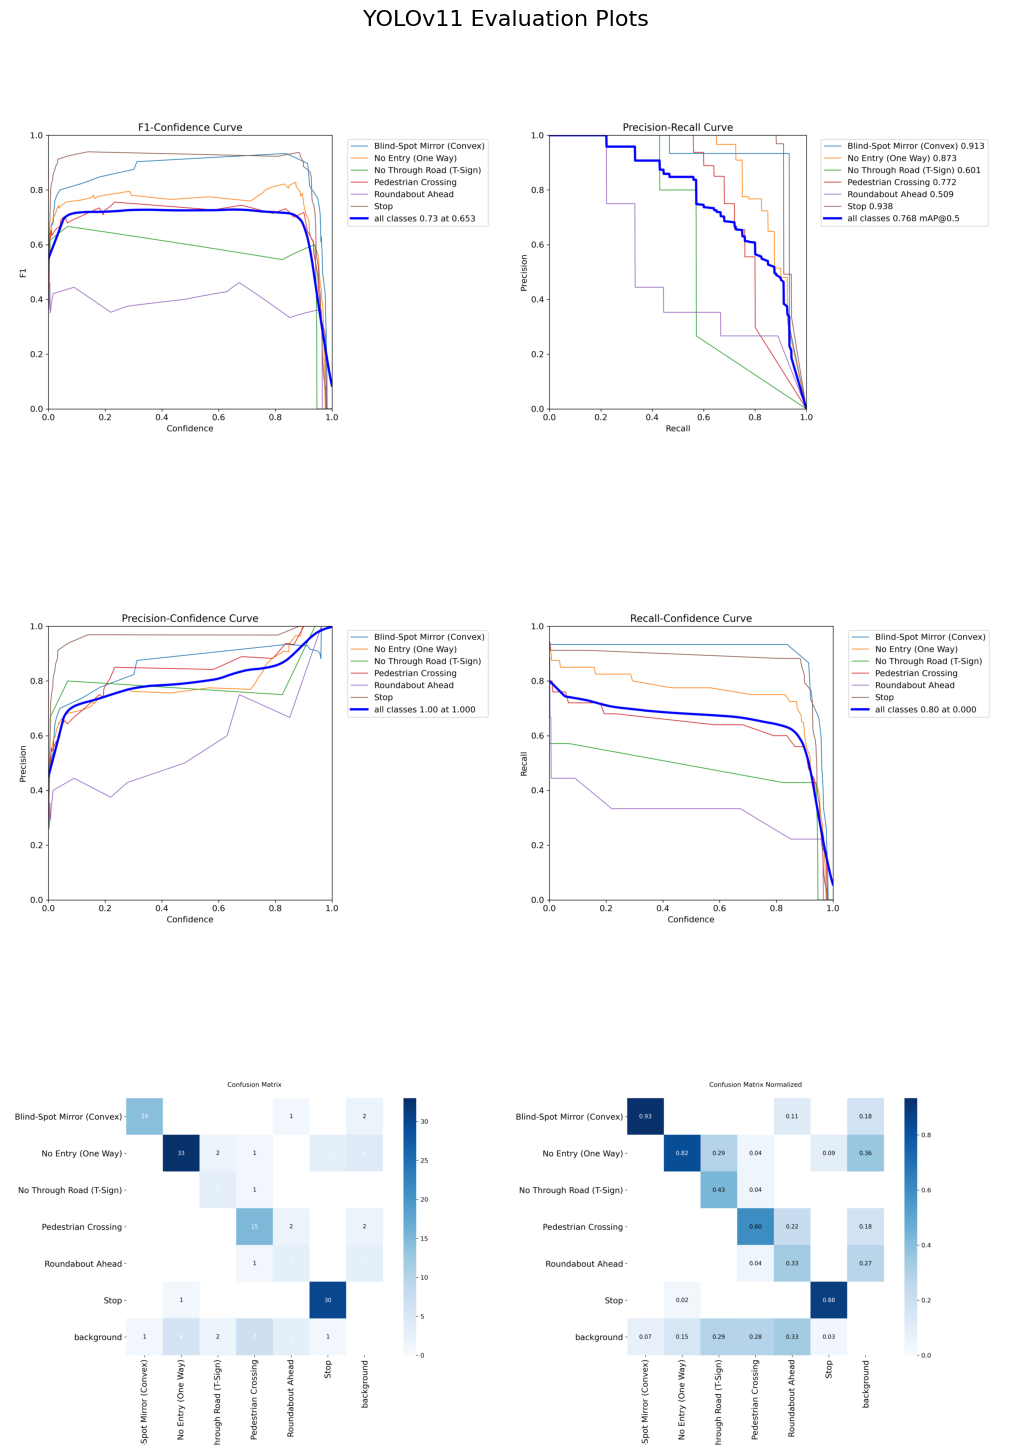

In [ ]:
plot_patterns = (
    'confusion_matrix*.png',
    '*curve*.png',
)

show_images_from_folder(
    val_dir,
    title='YOLOv11 Evaluation Plots',
    patterns=plot_patterns
)



### Labels and Predictions

Shows sample images with predicted bounding boxes and labels, allowing for a visual comparison between model predictions and ground truth.

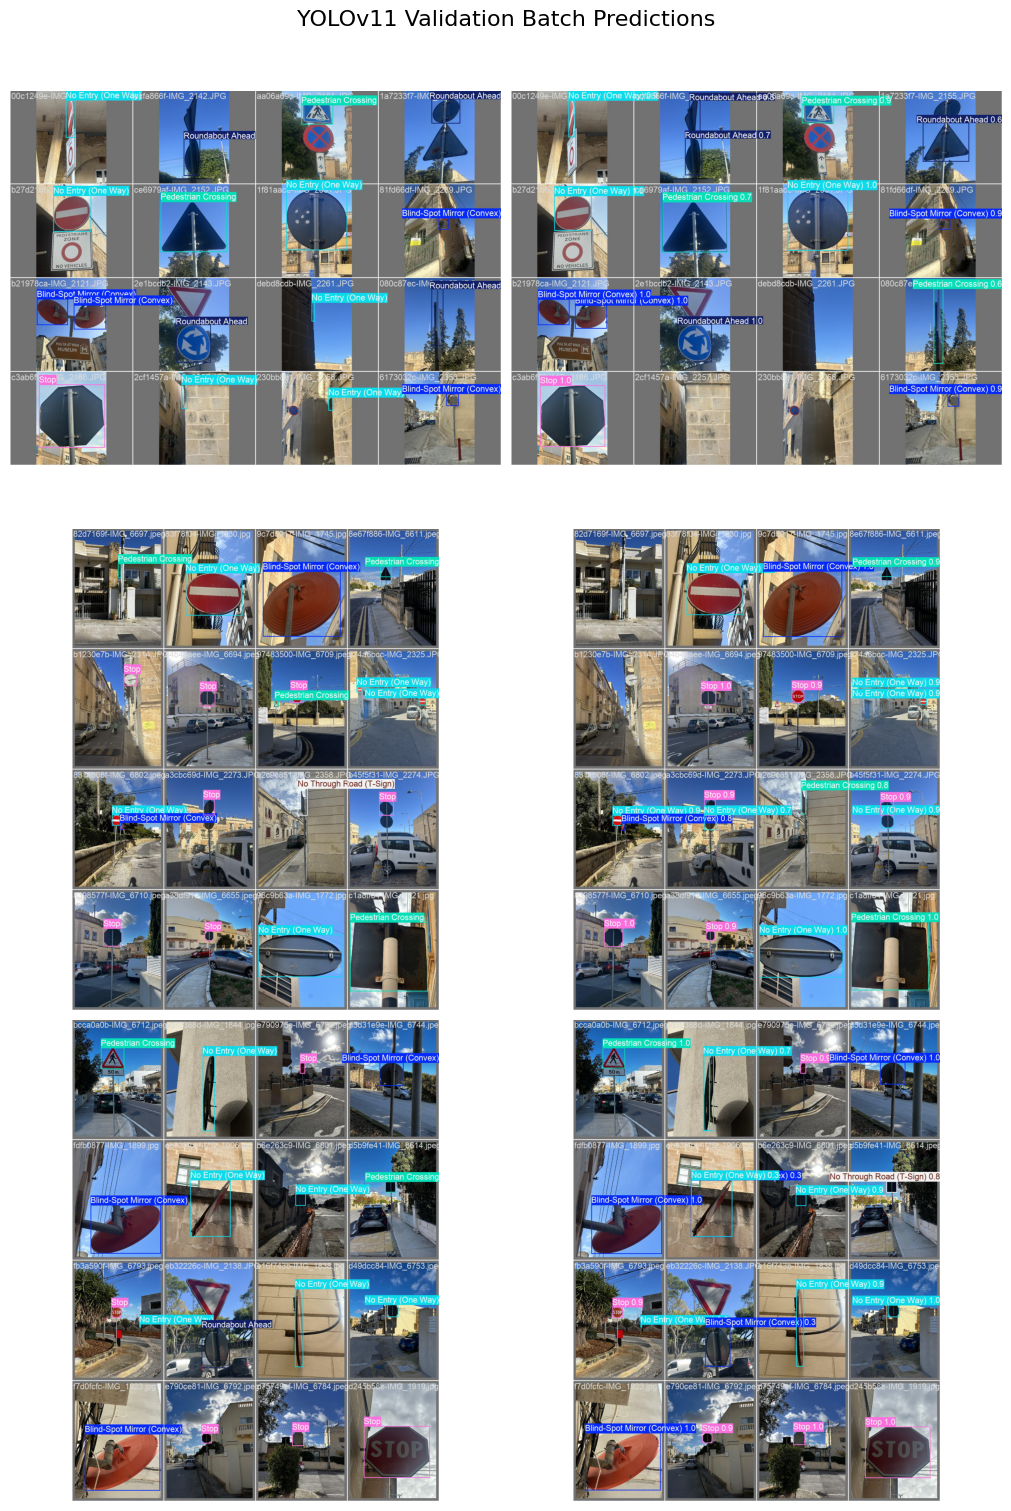

In [ ]:
val_batch_patterns = ('val_batch*.jpg', 'val_batch*.png')

show_images_from_folder(
    val_dir,
    title='YOLOv11 Validation Batch Predictions',
    patterns=val_batch_patterns
)
